**Введение** Представим, что вы хотите разработать модель, анализирующую тональность текста. 

Вы загрузили датасет...

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/esolovev/ling2019/master/module2/twi_data.csv', encoding='utf-8', sep=';')

In [3]:
df.head()

,target,date,text
0,4,Tue Jun 02 02:59:24 PDT 2009,@JackAllTimeLow hope it went good! i couldnt m...
1,0,Sat Jun 06 00:25:20 PDT 2009,@SDI8732 Idk how to do it!!!
2,0,Fri Jun 05 12:07:23 PDT 2009,"@kmwindmill is here ! woop woop , would be bet..."
3,4,Mon Jun 01 14:55:06 PDT 2009,@Daydreamer1984 He explains the tailer better
4,0,Sat Jun 20 15:39:44 PDT 2009,still trying to get a pic on this twitter thin...


In [4]:
y = df['target'].replace(4, 1)

del df['date']
del df['target']

... выделили из него какие-то признаки ...

In [7]:
transformed_texts = CountVectorizer(stop_words='english',
                                    max_df=0.95,
                                    min_df=3,
                                    ngram_range=(1,3),
                                    analyzer='word',).\
                    fit_transform(df.text.values).\
                    toarray() #конвертируем из разреженной матрицы в обычную, потому что PCA в sklearn не поддерживает sparse матрицы

print(transformed_texts.shape)

(40000, 16737)


... и разделили выборку на обучающую и тестовую.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(transformed_texts, y, train_size=0.5, stratify=y, random_state=123)

А теперь посмотрим, как долго будет обучаться, например, случайный лес.

In [11]:
%%time

RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(X_train, y_train)

CPU times: user 16min 41s, sys: 10.8 s, total: 16min 52s
Wall time: 3min 43s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

4 минуты - это слишком долго (причём это время обучения на 8-ядерном процессоре). 

А если уменьшить размерность?

In [9]:
%%time

pca = PCA(n_components=150)
reducted_train = pca.fit_transform(X_train)

CPU times: user 1min, sys: 6.87 s, total: 1min 7s
Wall time: 44.3 s


In [10]:
reducted_train.shape

(20000, 150)

In [11]:
%%time

RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(reducted_train, y_train)

CPU times: user 31.7 s, sys: 181 ms, total: 31.8 s
Wall time: 9.02 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Уже лучше (если мы один раз уменьшаем размерность, а затем обучаем много разных моделек на получившемся датасете, среднее время на обучение получается сильно лучше даже с учетом того, что мы потратили минуту на PCA). А вот посмотреть, насколько ухудшается или улучшается качество при использовании PCA - ваша задача.

*Совет*: можете сначала написать код для меньшего количества параметров, решающее все задание, отладить его, а уже потом запустить его на всех параметрах. Так вы сэкономите время, затрачиваемое на обучение.

**Задание 1**
Возьмите 5 различных значений для числа главных компонент в PCA. Для каждого из данных значений параметров решающего леса выберите лучшую модель с помощью GridSearchCV на 3 фолдах (**важно**: чтобы графики из второго задания были корректны, вам нужно, чтобы разбиение на фолды было одинаковое для всех значений числа компонент). Используйте accuracy как метрику качества.

* max_depth: 3, 6, 9, 12, 50
* n_estimators: 25, 50, 75, 100


**Задание 2**
Отобразите на одной картинке два графика (по оси X отложено число главных компонент в PCA):

1) Качество лучшей модели на тестовой выборке

2) Среднее качество на 3 фолдах при подборе параметров (для лучшей модели)

3) Общая доля объяснённой дисперсии для выбранного числа компонент (для лучшей модели).

## Задание 1

In [152]:
numb_components = [2, 3, 4, 5, 6]

In [153]:
rfc = RandomForestClassifier(random_state=3)
max_depth = [3, 6, 9, 12, 50]
n_estimators = [25, 50, 75, 100]
params = {"n_estimators" : n_estimators, "max_depth": max_depth}

In [154]:
cv_rfc = GridSearchCV(estimator=rfc, param_grid=params, cv=3, scoring="accuracy")

In [167]:
accuracies = []
k_fold_mean_scores = []
cum_expl_var = []

for n_comp in numb_components:
    pca = PCA(n_components=n_comp)
    reducted_train = pca.fit_transform(X_train)
    reduced_test = pca.fit_transform(X_test)
    
    cv_rfc.fit(reducted_train, y_train)
    
    best_scor = max(cv_rfc.cv_results_['mean_test_score'])
    k_fold_mean_scores.append(best_scor)
    
    cumulative=np.cumsum(pca.explained_variance_ratio_)
    cum_expl_var.append(cumulative[-1])
    
    best_param = cv_rfc.best_params_
    rfc_best = RandomForestClassifier(random_state=5, n_estimators=best_param["n_estimators"],
                                  max_depth=best_param["max_depth"])
    rfc_best.fit(reducted_train, y_train)
    y_pred = rfc_best.predict(reduced_test)
    accuracies.append(accuracy_score(y_test, y_pred))

Про общую долю об. дисперсии было частично взято из https://your-scorpion.ru/log-loss-pca/

## Задание 2

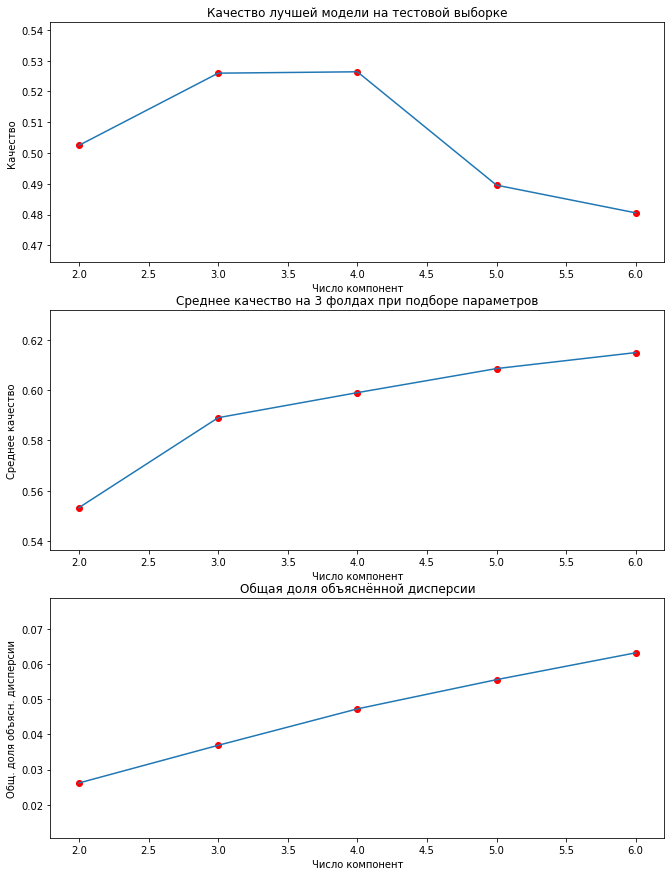

In [172]:
fig, axs = plt.subplots(3, figsize=(11, 15))

axs[0].scatter(numb_components, accuracies, color="red")
axs[0].set_title('Качество лучшей модели на тестовой выборке')
axs[0].set_xlabel('Число компонент')
axs[0].set_ylabel('Качество')
axs[0].plot(numb_components, accuracies)

axs[1].scatter(numb_components, k_fold_mean_scores, color="red")
axs[1].set_title('Среднее качество на 3 фолдах при подборе параметров')
axs[1].set_xlabel('Число компонент')
axs[1].set_ylabel('Среднее качество')
axs[1].plot(numb_components, k_fold_mean_scores)

axs[2].scatter(numb_components, cum_expl_var, color="red")
axs[2].set_title('Общая доля объяснённой дисперсии')
axs[2].set_xlabel('Число компонент')
axs[2].set_ylabel('Общ. доля объясн. дисперсии')
axs[2].plot(numb_components, cum_expl_var)